In [17]:
import cv2
from PIL import Image
import pytesseract

In [18]:
import matplotlib.pyplot as plt

In [19]:
imag_file= "test_img.png"
img= cv2.imread(imag_file)
cv2.imshow("Original",img)
cv2.waitKey(0)

-1

In [64]:
def display(imag_file):
    dpi=80
    img_data = plt.imread(imag_file)
    height, width = img_data.shape[:2]

    #What size does the fig need to be in inches to fit the image?
    figsize= width/float(dpi),height/float(dpi)

    #create a figure of the right size with one axes that takes up the full fig
    fig = plt.figure(figsize=figsize)
    ax=fig.add_axes([0,0,1,1])

    #hide spines, ticks, etc
    ax.axis("off")

    #Display image
    ax.imshow(img_data,cmap="gray")
    plt.show()

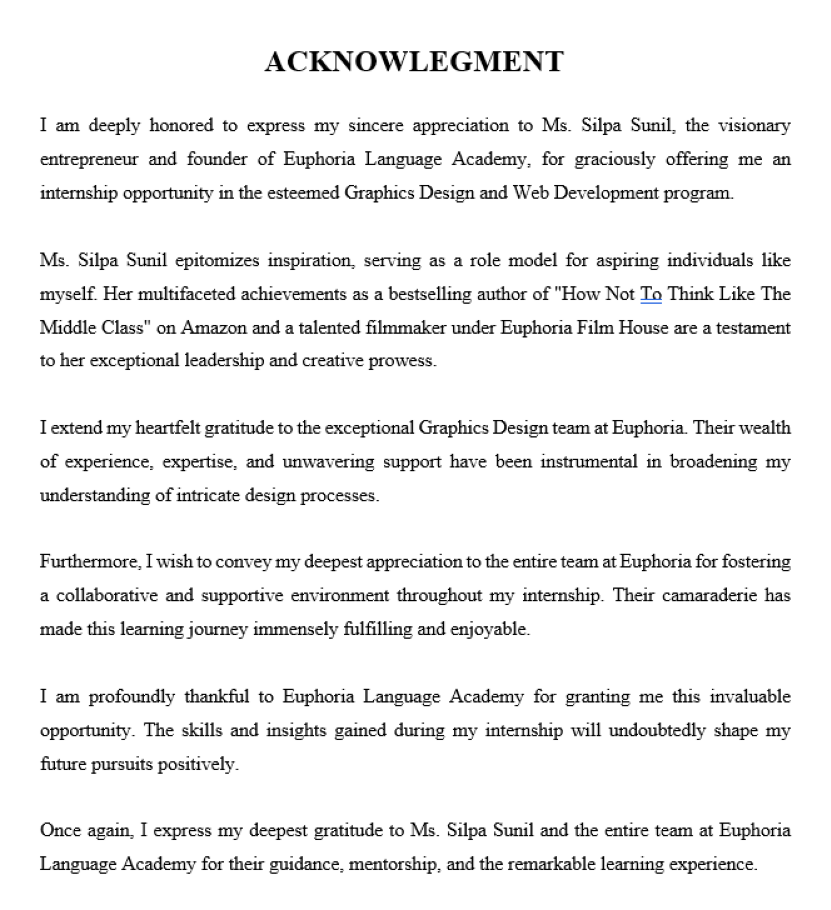

In [65]:
display(imag_file)

# Inverted Images

True

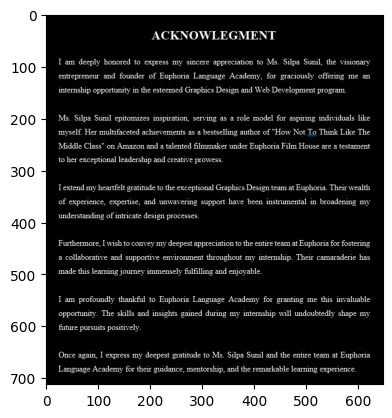

In [66]:
inverted_imag=cv2.bitwise_not(img)
plt.imshow(inverted_imag)
cv2.imwrite("temp/inverted.png",inverted_imag)


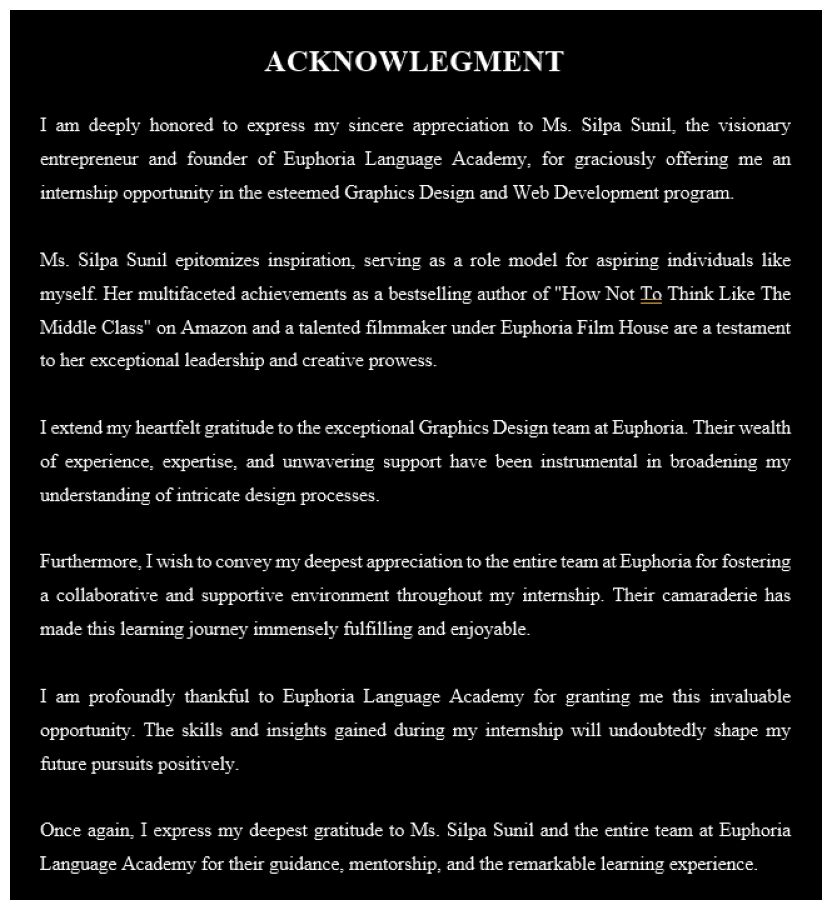

In [67]:
display("Temp/inverted.png")

# Rescaling
An optimal range for the image to be in to have optimized OCR, the range is defined by the height of the chr which comes down to the dpi, this is in the tesseract OCR doc 

# Binarization

In [68]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_image = grayscale(img)
cv2.imwrite("temp/gray.png", gray_image)

True

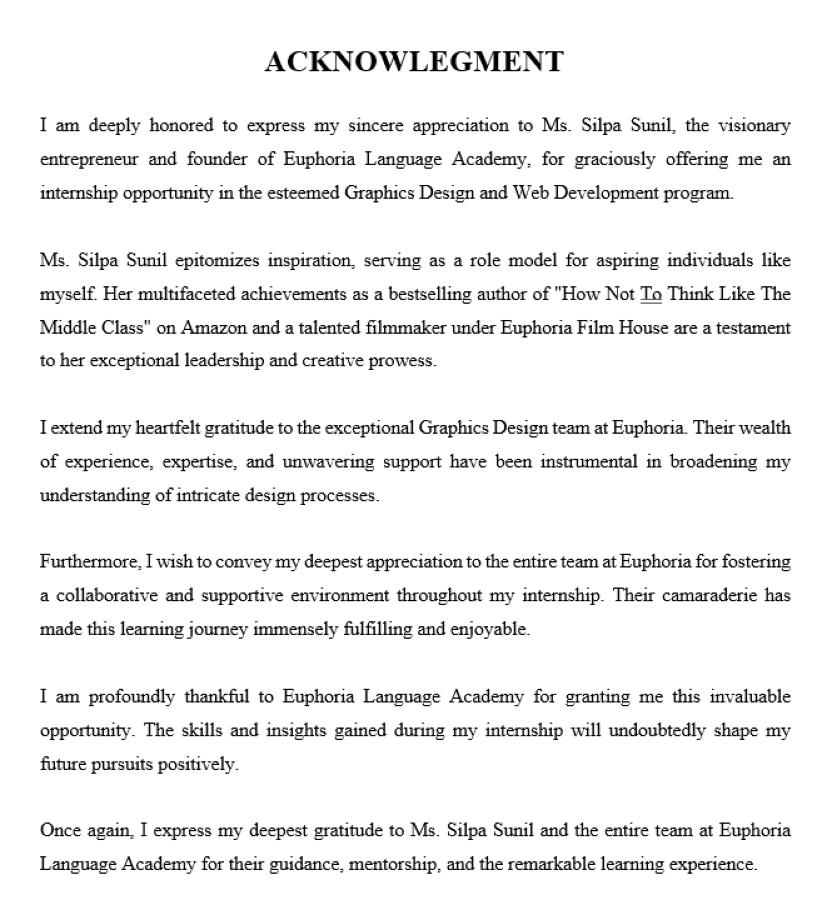

In [69]:
display("temp/gray.png")

# threshold 
a thresholding operation with a threshold value of 210, and saves the resulting binary image (im_bw) as a JPEG file named "bw_image.jpg" in the "temp" directory. The resulting image will have pixel values of either 0 or 230 based on whether the pixel intensities in the original grayscale image were below or above the threshold of 210, respectively.

In [82]:
thresh, im_bw = cv2.threshold(gray_image, 220, 230, cv2.THRESH_BINARY)
cv2.imwrite("temp/bw_image.jpg", im_bw)

True

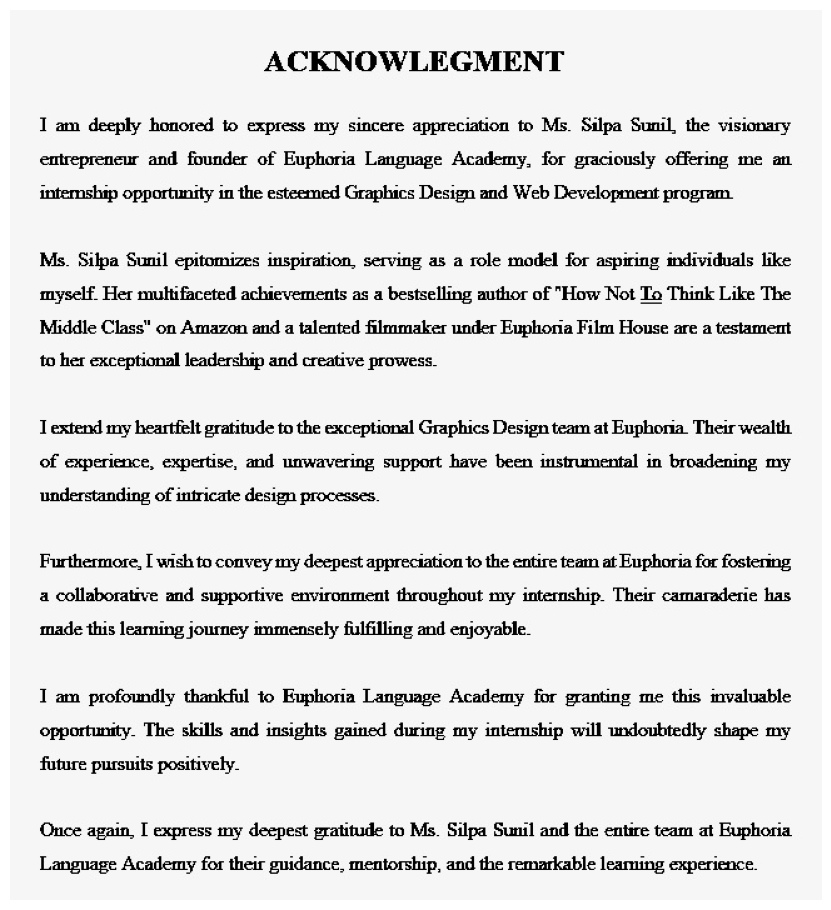

In [83]:
display("temp/bw_image.jpg")

# Noise Removal

In [72]:
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

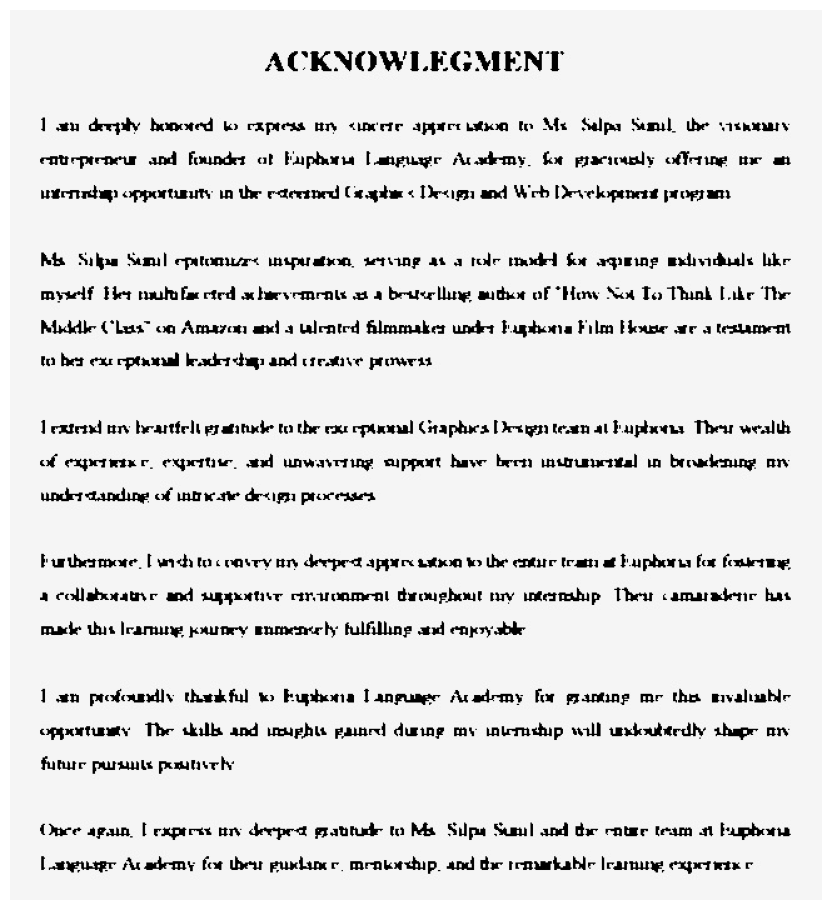

In [73]:
no_noise = noise_removal(im_bw)
cv2.imwrite("temp/no_noise.jpg", no_noise)
display("temp/no_noise.jpg")

# Dilation and Erosion



Dilation and erosion is used to handle image that has, the background the surface is black and the text and the font color is white.

image is inverted before applying dilation and eosion

### Thinning the font ( erosion is thinning the pixel )

In [74]:
def thin_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

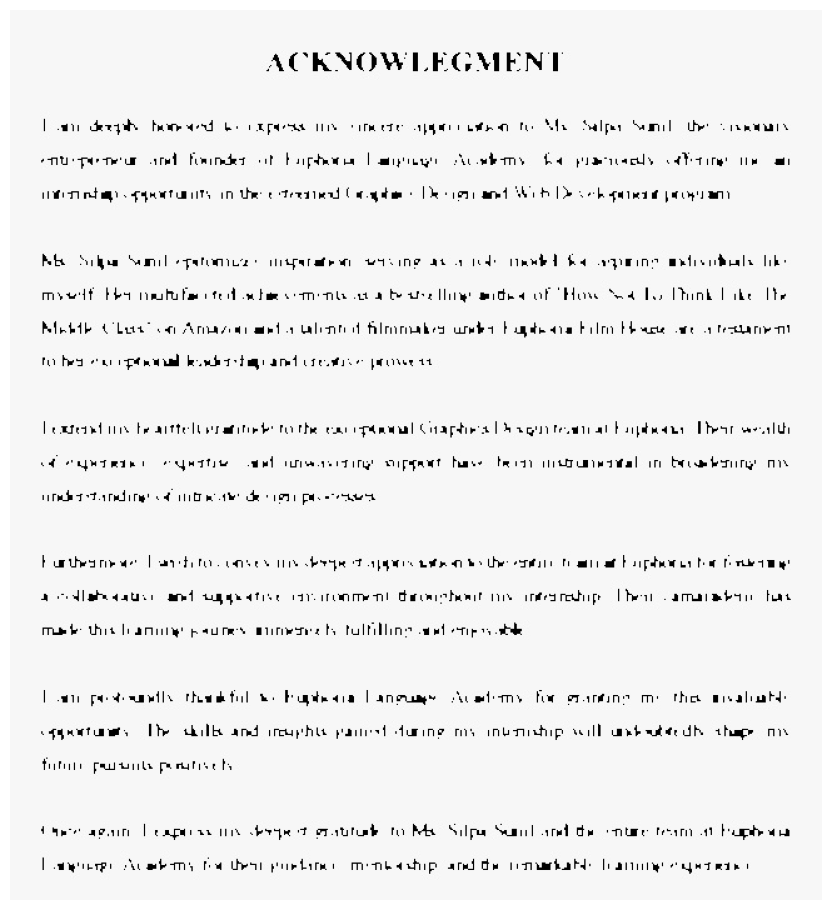

In [75]:
eroded_image = thin_font(no_noise)
cv2.imwrite("temp/eroded_image.jpg", eroded_image)
display("temp/eroded_image.jpg")

### Dilation is thinking the text font thick

In [85]:
def thick_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

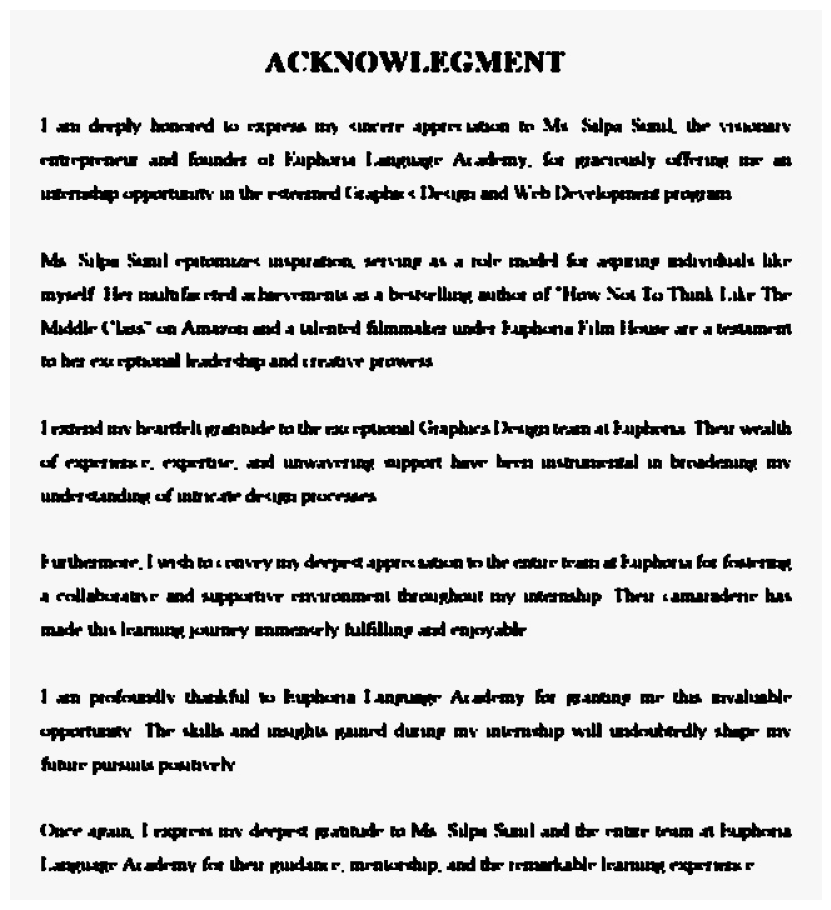

In [86]:
dilated_image = thick_font(no_noise)
cv2.imwrite("temp/dilated_image.jpg", dilated_image)
display("temp/dilated_image.jpg")

# Rotation / Deskewing

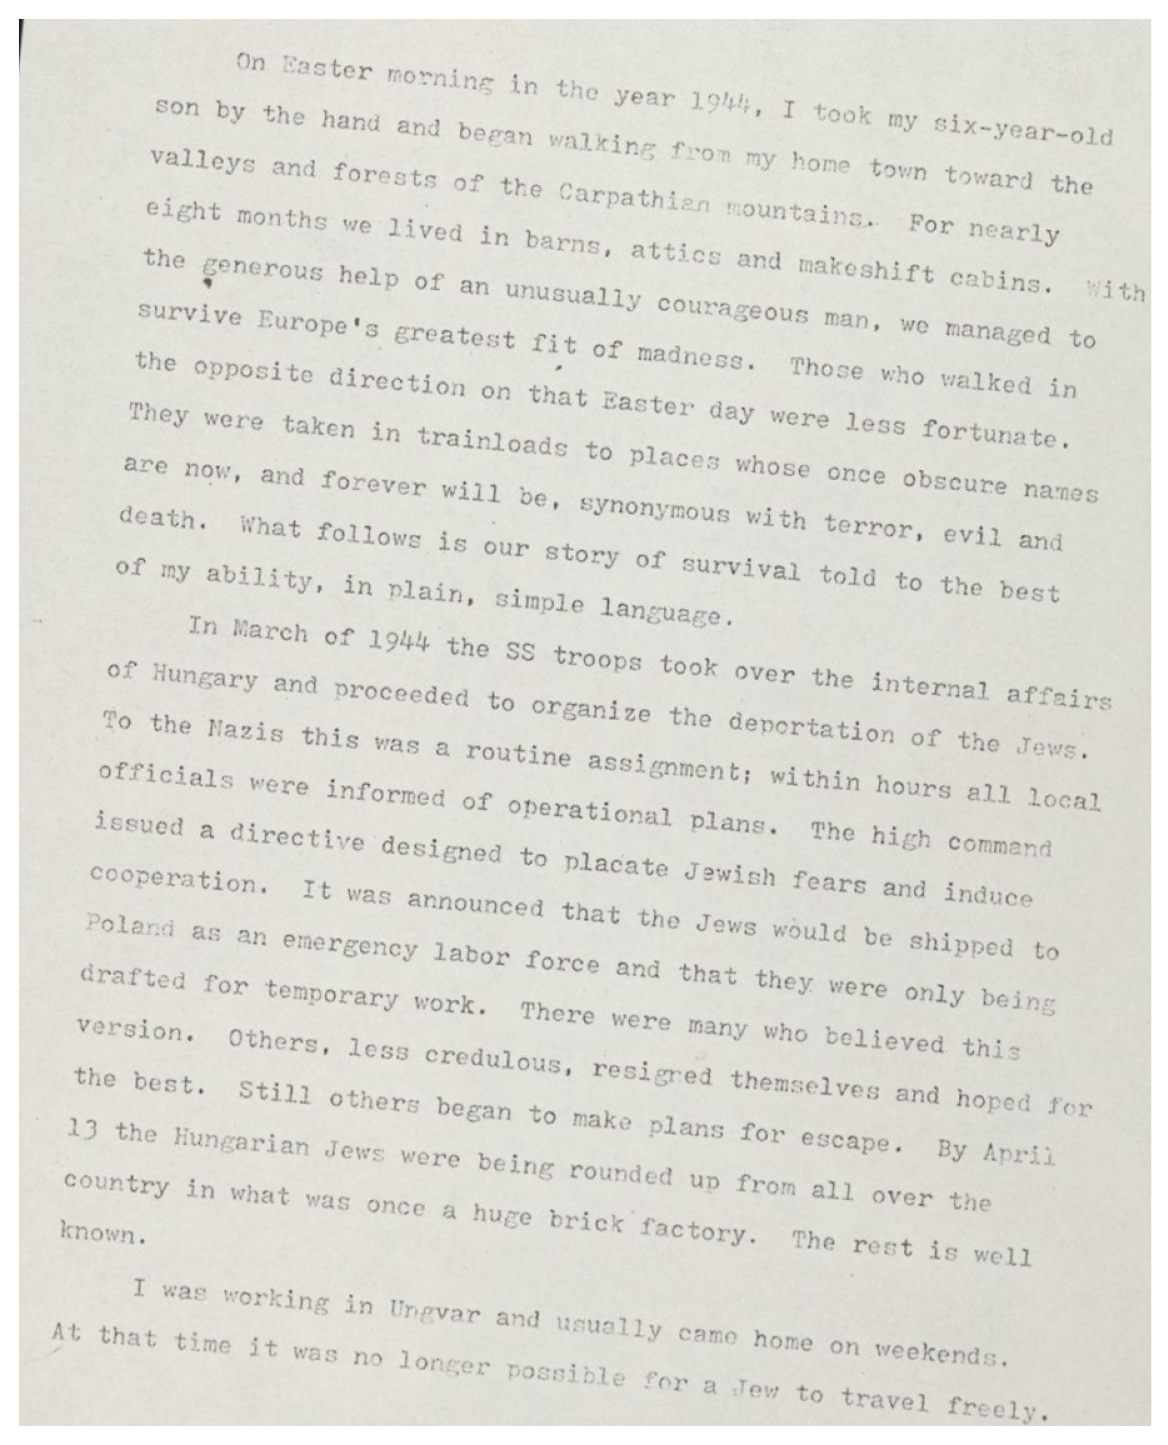

In [94]:
new = cv2.imread("data/test_img2.png")
display("data/test_img2.png")


In [95]:
# Source: https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df

import numpy as np

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [96]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [97]:
fixed = deskew(new)
cv2.imwrite("temp/rotated_fixed.jpg", fixed)

28


True

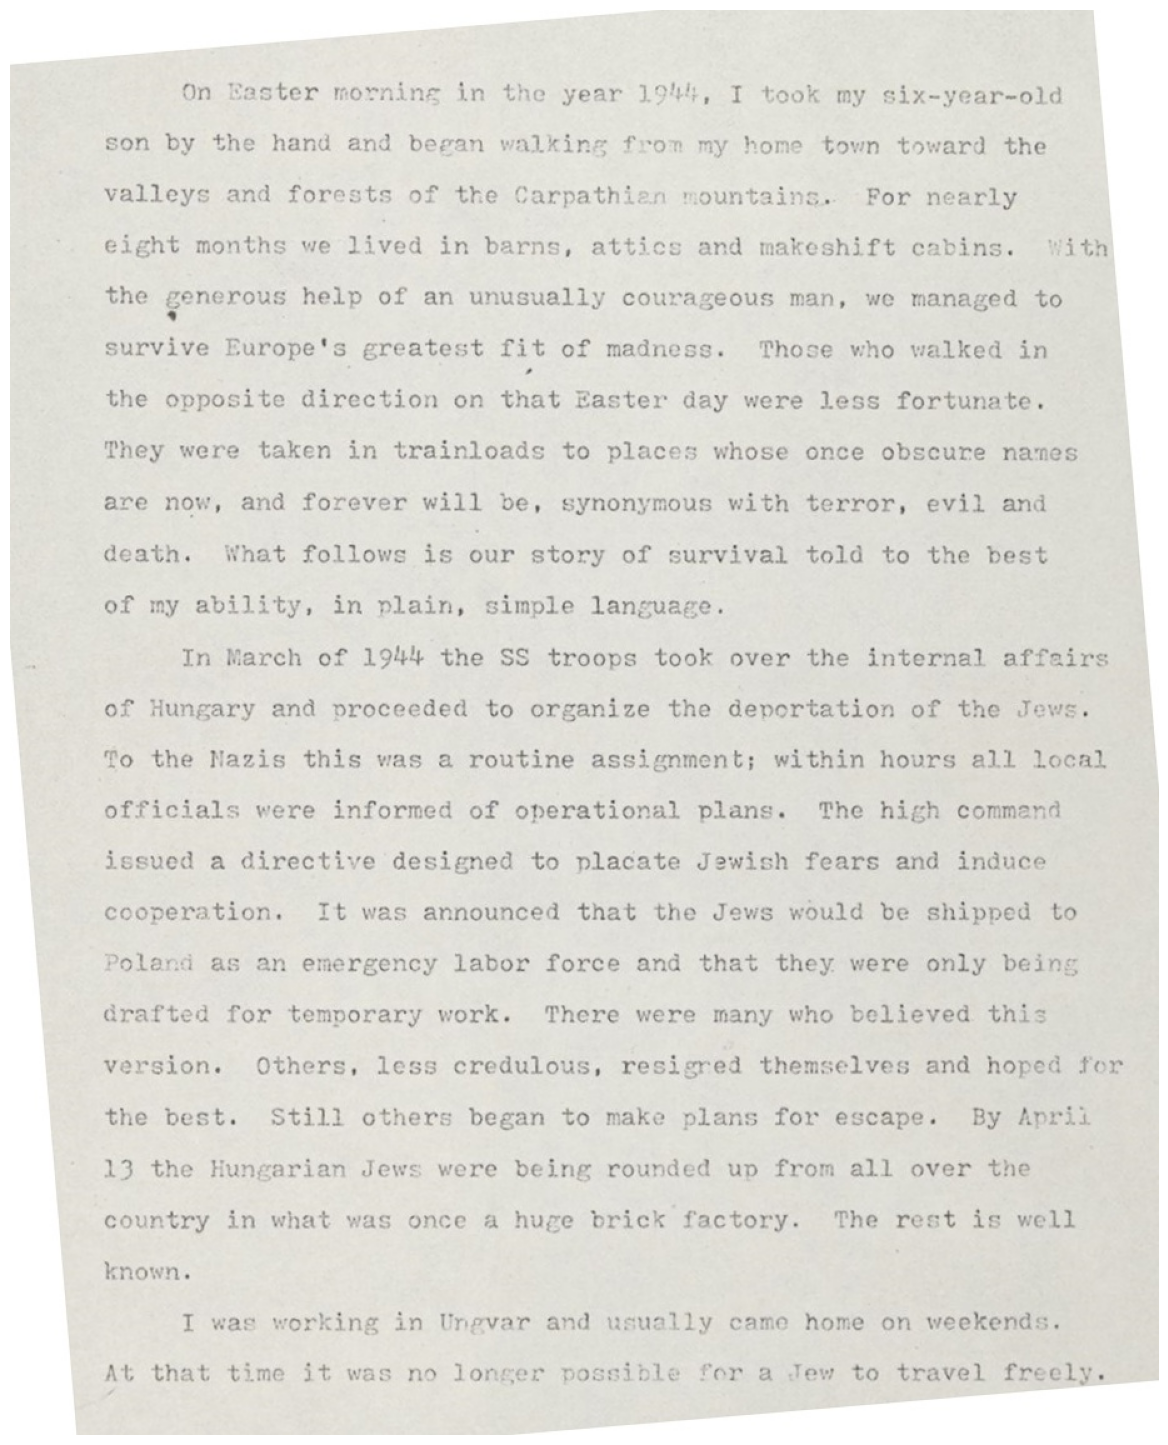

In [98]:
display("temp/rotated_fixed.jpg")

# Remove Borders

# Missing Borders